# Diffuse Reflections

F. Estrada - CSC D18 - Computer Graphics, Sep. 2019

Modified by Mustafa Quraish, 2019

---

So far, in your ray tracer you've only dealt with materials that are perfectly specular. Light is only ever bounced in one direction corresponding to the perfect reflection direction of the incoming rays.

Not many materials behave in exactly that way. Many metals, plastics, and other polished surfaces exhibit strong reflection around the perfect specular direction, but also significant and visible reflection at angles around the perfect reflection direction.

This script will show you how implement diffuse reflection
for such surfaces.

---

The idea is as follows:

   - Given an incoming ray of light at direction $\vec{d}$

   - Draw a reflection direction from a *distribution* of possible reflection directions, centered at the direction $\vec{m}$ for perfect reflection.
   
   - Depending on the shape of this distrubution, the resulting direction for reflection will be allowed to deviate from $\vec{m}$.

   - Given the sampled reflection direction $\vec{r}$, obtain a global reflection colour by raytracing a ray in direction $\vec{r}$.

   - Repeat the process above $N$ times, so as to draw enough samples from the distribution of possible reflection directions.

   - The final colour for the pixel that generated the initial ray in direction $\vec{d}$ is the average of the colours of all the randomly-sampled, reflected rays.

---

**Question:** What distribution would give you a perfectly diffuse surface? What about mirror?

Complete the code in the sections below to implement diffuse reflection, then feel free to add it to your ray tracer!

----


Obviously, we don't want to be implementing *all* the features in a fully-fleshed out ray-tracer (this is only a lab!). So, here's how the setup is going to work:

- The scene contains a single unit sphere located at the origin. We will be implementing diffuse reflections for this object.

- The camera points directly at this sphere.

- Behind the camera (not within direct view) is a plane that is positioned so it is reflected by the sphere. It is texture-mapped with a procedurally generated checkerboard. It is parallel to the $X-Y$ plane, and goes through the point $(0,0,-2)$

- We don't actually need recursion here - there is only one reflective sphere, and the light that bounces off it will either hit the plane or nothing at all.

---

Cool? Let's get to some actual code now. The following function computes the intersection of a ray (bounced off the sphere) with the plane.

- The inputs are the position and the direction vectors of the ray, $\vec{p}$ and $\vec{d}$.
- The return value is the colour at the point of intersection `[R, G, B]`
    - If there is no intersection, the colour returned is `[0, 0, 0]`


In [ ]:
%%file IntersectPlane.m

function [rgb] = IntersectPlane(p, d)
  PW = 500000;      % Width/height of the textured plane
  PH = 500000;
  SW = 1;           % Width/height of each square in the checkerboard
  c0 = [0, 0, 0]';  % Colours for the squares in the checkered texture
  c1 = [1, 1, 1]';
  
  rgb = [0, 0, 0]'; % Default return value if no intersection
  
  if (d(3) < 0) % Why do we need this?
    lmbd = (-3 - p(3)) / d(3);
    iP = p + (lmbd * d);
    % Check bounds on X and Y
    if (abs(iP(1)) < PW / 2 && abs(iP(2)) < PH/2)
      % Ray hits plane, figure out the colour
      if (mod((floor(iP(1) / SW)) + (floor(iP(2) / SW)), 2) == 0)
          rgb = c0;
      else
          rgb = c1;
      end
    end
  end
end

---

With that done, we can actually compute the colour of a ray bouncing off our sphere. The following code computes the perfect reflection direction off the sphere, and computes the colour as a result of intersection with the plane before returning it to the `RayTrace()` function below. For now, look through the rest of the code and run the ray-tracer to generate the default image, then come back to the implementation section below.

---

Now that you (hopefully) understand how the code works and can see the perfect reflection, Implement in the region marked `TODO` the diffuse reflection algorithm given at the start! The inputs are:

- $\vec{d}$: incoming ray direction
- $\vec{n}$: normal at the point of intersection on the sphere (Note: this is also the point of intersection!)
- $\sigma$: standard deviation for diffuse reflection direction
- $N$: total number of samples for diffuse reflection

The function should return the average reflected colour across the $N$ samples.

### *So, how does diffuse reflection actually work?*

Instead of the single ray in the direction of perfect reflection, here's what you want to do:
- Compute the direction $\vec{\textit{ref}}$ of perfect reflection as below.
- You will randomly perturb this direction so that:
    * The resulting vector is roughly aligned with $\vec{\textit{ref}}$
    * It can be perturbed in any direction with equal probability
    * The distribution of the $N$ perturbed vectors is centered around $\vec{\textit{ref}}$, has standard deviation $\sigma$, and is Gaussian.
    
*> There are many ways to implement this, the point is to experiment and see what works! You may find the documentation for `randn()` helpful.*

What you're doing, in essence, is generating a Gaussian distribution of vectors around $\vec{\textit{ref}}$, with a tunable $\sigma$. If $\sigma$ is close to $0$, these vectors are very close to $\vec{\textit{ref}}$ and you get close to perfect mirror reflection. If $\sigma$ is bigger, you start to see the reflection becomes more blurry - this is diffuse reflection!

Here's some examples:

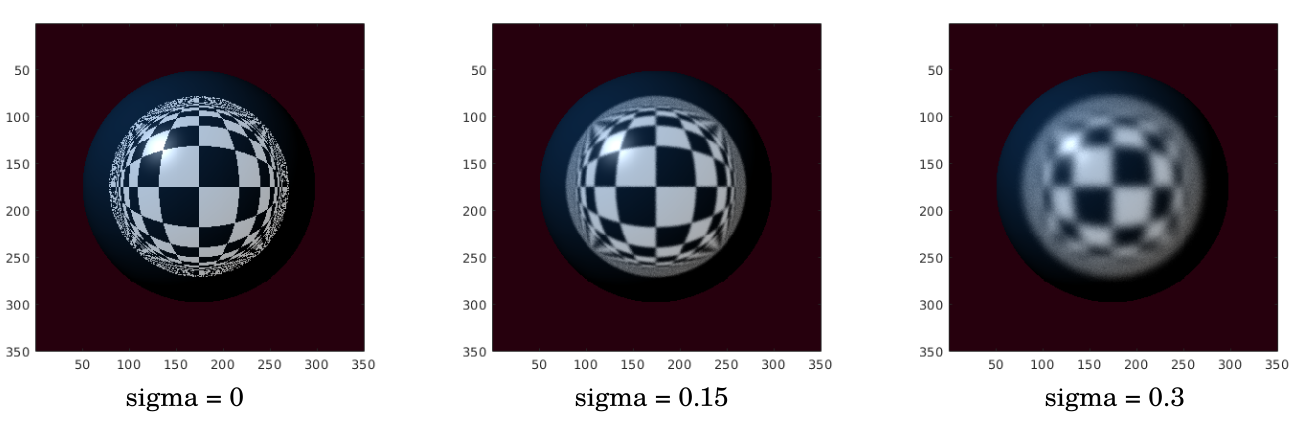


In [ ]:
%%file DiffuseReflection.m

function [rgb] = DiffuseReflection(d, n, sigma, N)
  rgb = [0, 0, 0]'; % Start with no colour
  
  for i = 1:N
    %%%%%%%%%%%%%%%%%%%% TODO %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    % Replace this code to compute the reflection direction
    % based on a normal distribution centered at the perfect
    % reflection direction, and the standard deviation `sigma`
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    ref = d + (2 * (n'*-d)*n);
    rgb = rgb + IntersectPlane(n, ref);
  end
  
  rgb = rgb / N;
end

---

Now, for the meaty part, the Ray tracing! Dont worry - we've implemented this for you already. Make sure you still look at the code and understand what's going on. You've already done all this in your A2, so hopefully nothing should be new. The only difference is that we're working exclusively in *world coordinates* here.

Since the textured plane is out of view of the camera, the intersection with the plane is done inside the render loop. (Yes Joe, it's not the best design choice, but it's fine for now). We'll compute the colour using the Phong model, except without the ambient component (It adds nothing to this scene). 

The inputs are:

- $\textit{phong}$: a column vector containing $[r_d, r_s, r_g, \alpha]$, the diffuse, specular, global components, and shinyness value
- $\textit{LS}$: a column vector containing the $[x, y, z]$ location of the lightsource.
- $N$: number of diffuse reflection samples
- $\sigma$: sigma for diffuse reflection
- $\textit{w}$: width/height of the image window in world coords (square for now)
- $\textit{sx}$: width/height of the image in pixels (square for now)

---

*Note: The colour of the sphere and background are hardcoded in here for now. Making a fully modifiable ray-tracer is not the point of this exercise. Feel free to change how this works - **after** you're done with the core stuff.*

In [ ]:
%%file RayTrace.m

function [im] = RayTrace(phong, LS, N, sigma, w, sx)

  e = [0, 0, -3]'; % Camera is on the optical axis, up direction is the Y axis,
                   % image plane is parallel to the XY plane
  f = 1; % Focal distance is 1, in the direction of the positive Z
         % Axis (i.e. the principal point is at [0 0 -2]

  im = zeros([sx, sx, 3]);
  sphere_col = [.15, .55,   1]'; % RGB colour for the sphere
  background = [.15,   0, .05]'; % Background colour
  WTx = -(w / 2.0); % X world coordinate for the top-left of the image window
  WTy =  (w / 2.0);  % Y world coordinate for the top-left of the image window

  % Ray tracing loop
  for i = 1:sx
    for j = 1:sx

      Pij = [ WTx + ((i * w) / (sx - 1)),
              WTy - ((j * w) / (sx - 1)),
              e(3) + f
            ];
      dij = Pij - e;
      dij = dij / norm(dij);

      % Ray-sphere intersection
      A = dij' * dij;
      B = Pij' * dij;
      C = (Pij' * Pij) - 1;
      D = (B^2) - (A * C);

      if (D <= 0)
        % No intersection, just set to background colour
        im(i, j, :) = background;
        continue;
      end;

      sqD = sqrt(D);
      l1 = max(0, (-B + sqD) / A);
      l2 = max(0, (-B - sqD) / A);
      lmbd = min(l1, l2);

      if (lmbd <= 0)
        continue;
      end;

      % Shading setup
      iP = Pij + (lmbd * dij);
      n = iP; % Normal = P.O.I for unit sphere at orig.
      s = LS - iP; % Towards LS
      s = s / norm(s);
      m = -s + (2 * (n' * s) * n); % Perfect refl.

      % Phong components
      diffuse  = phong(1) * sphere_col * max(0, n' * s);
      specular = phong(2) * (max(0, m' * -dij)^phong(4));
      % Notice that the global colour comes from DiffuseReflection()
      global_r = phong(3) * DiffuseReflection(dij, n, sigma, N);
      
      colour = diffuse + specular + global_r;
      colour(find(colour > 1)) = 1; % Clip values if needed
      im(i, j, :) = colour;
    end
  end
end

Let's test out our simple ray tracer - first with no diffuse reflections! The following code calls the `RayTrace()` function with the appropriate params and plots out the image. *Try changing the different components of the phong model to see if it makes sense!*

In [ ]:
%plot inline

%%%%%%%  diff  spec  glob  shny 
phong = [0.25, 0.35, 0.65, 25.0]';
LS    = [-2, 2, -3]';

%%%%%%%%%%%%%%%%%%%%%%%%%  N  sgma  w   sx
[im] = RayTrace(phong, LS, 1, 0.00, 1, 350);
imagesc(im); axis image;

Cool, right? A little proof-of-concept ray tracer in less than $100$ lines of code to test out some new features!

---

Once you've finished implementing the `DiffuseReflection()` function above, the following code should generate an image with a diffuse reflection. Try messing around with the $\sigma$ value to see if it makes sense! Note that this will take some time if you increase the number of samples - the convenience of Matlab comes at the cost of speed.

In [ ]:
% plot inline

%%%%%%%%%%%%%%%%%%%%%%%%%%  N  sgma  w   sx
[im] = RayTrace(phong, LS, 50, 0.25, 1, 350); 
imagesc(im); axis image;

---

## Exercises:

1. There's no reason why the material will reflect light equally in every direction. Metal is often 'burnished', which means it's polished in such a way that the light reflects differently depending on the direction at which the light hits the material. See what happens if you allow for different $\sigma$ values for the $\theta$ and $\phi$ directions. In particular, make one $\sigma$ very tiny compared to the other one.


2. Turn this script into a more functional ray-tracer! :) You don't need to support planes and cylinders - but you  should handle transformed objects, and more than $1$ object at that. It's a great way to find out if you've really understood the entire ray tracing process. Plus, it's significantly easier than in C!


3. Have fun, and mess around with the prodecural texture generation and diffuse reflections! Feel free to implement these in your assignment code. Your objects will need to store an additional parameter for the $\sigma$, or 'roughness' of the surface, and you need the sampling loop that perturbs the reflection direction and traces $N$ rays to figure out the reclection component.
